In [1]:
import os

import torch
import numpy as np
import mne

import multiprocessing
from multiprocessing import Pool

import pandas as pd

from scipy.io import wavfile
import matplotlib.pyplot as plt

In [2]:
def plot_psd(data, subject=0, channel=0, fs=100):
    x_t = data[subject][channel]

    N = x_t.shape[-1]
    t = torch.arange(0, N) * 1/fs

    plt.figure(figsize=(15, 4))

    plt.subplot(211)
    plt.plot(t, x_t)
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')

    plt.subplot(212)
    plt.psd(x_t, 1024, fs)
    plt.xlabel('f [Hz]')

    plt.tight_layout()
    plt.show()

### Audio (AudioSet)

In [ ]:
def list_files(rootdir):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)
        if os.path.isdir(curr_object): 
            files += list_files(curr_object)
        elif ".wav" in curr_object:
            files.append(curr_object)

    return files

# Replace 'directory_path' with the path of the directory you want to search
# directory_path = '/home/oturgut/data/AudioSet/archive/train_wav'
directory_path = '/home/oturgut/data/AudioSet/archive/train_wav/'
files = list_files(directory_path)

In [ ]:
len(files)

In [ ]:
files[0]

In [ ]:
tensors = []
curr_file = ""

for file in files:
    curr_file = file
    samplerate, data = wavfile.read(file)

    tensor = torch.from_numpy(data)
    if tensor.dim() == 1:
        tensor = tensor[..., None]

    tensor = tensor.transpose(1, 0)

    if tensor.shape[-1] == 0:
        continue
    
    tensor = tensor.to(dtype=torch.float32)
    tensor_normalised = ( tensor - tensor.mean(dim=-1, keepdim=True) ) / ( tensor.std(dim=-1, keepdim=True) + 1e-9 )

    tensors.append(tensor_normalised)

In [ ]:
len(tensors)

In [ ]:
tensors[0].shape

In [ ]:
tensors[0].max(), tensors[0].min(), tensors[0].mean(), tensors[0].std()

In [ ]:
len(files)

In [ ]:
def process_file(file):
    try:
        samplerate, data = wavfile.read(file)

        tensor = torch.from_numpy(data)
        if tensor.dim() == 1:
            tensor = tensor[..., None]

        tensor = tensor.transpose(1, 0)

        if tensor.shape[-1] == 0:
            return None
        
        tensor = tensor.to(dtype=torch.float32)
        tensor_normalised = (tensor - tensor.mean(dim=-1, keepdim=True)) / (tensor.std(dim=-1, keepdim=True) + 1e-9)

        return tensor_normalised
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        return None

if __name__ == "__main__":
    # Number of processes to use
    num_processes = 32

    with multiprocessing.Pool(processes=num_processes) as pool:
        tensors_ = pool.map(process_file, files)

    # Remove any None values (failed files)
    # tensors_ = [tensor for tensor in tensors_ if tensor is not None]

    print(f"Processed {len(tensors_)} files.")

In [ ]:
univariate = [tensor.shape for tensor in tensors if tensor.shape[0] == 1]
multivariate = [tensor.shape for tensor in tensors if tensor.shape[0] == 2]

In [ ]:
len(univariate), len(multivariate)

In [ ]:
subject = 100
data_audio = tensors[subject]

step = 10
plt.figure(figsize=(20, 4), dpi=80)

plt.subplot(2,1,1)
plt.plot(data_audio[0, ::step])

plt.subplot(2,1,2)
plt.plot(data_audio[1, ::step])

plt.tight_layout()
plt.show()

In [ ]:
step = 1
plt.figure(figsize=(20, 4), dpi=80)

plt.subplot(2,1,1)
plt.plot(data_audio[0, 10000:10178:step])

plt.subplot(2,1,2)
plt.plot(data_audio[0, :12000:step])

plt.tight_layout()
plt.show()

In [ ]:
mono_audio = [("audio_mono", tensor) for tensor in tensors if tensor.shape[0] == 1]
len(mono_audio)

In [ ]:
stereo_audio = [("audio_stereo", tensor) for tensor in tensors if tensor.shape[0] == 2]
len(stereo_audio)

In [ ]:
audioset = mono_audio + stereo_audio

In [ ]:
audioset[12250]

In [ ]:
audioset_float16 = [(data[0], data[1].to(dtype=torch.float16)) for data in audioset]

In [ ]:
# torch.save(audioset_float16, "/home/oturgut/data/processed/signalnet/audioset_20k_float16.pt")
# torch.save(audioset, "/home/oturgut/data/processed/signalnet/audioset_20k.pt")

In [66]:
audio0 = torch.load("/home/oturgut/data/processed/AudioSet/audioset_20k.pt")

In [67]:
audio0[0][1].shape, audio0[0][1].mean(), audio0[0][1].std() 

(torch.Size([1, 441000]), tensor(9.2037e-09), tensor(1.))

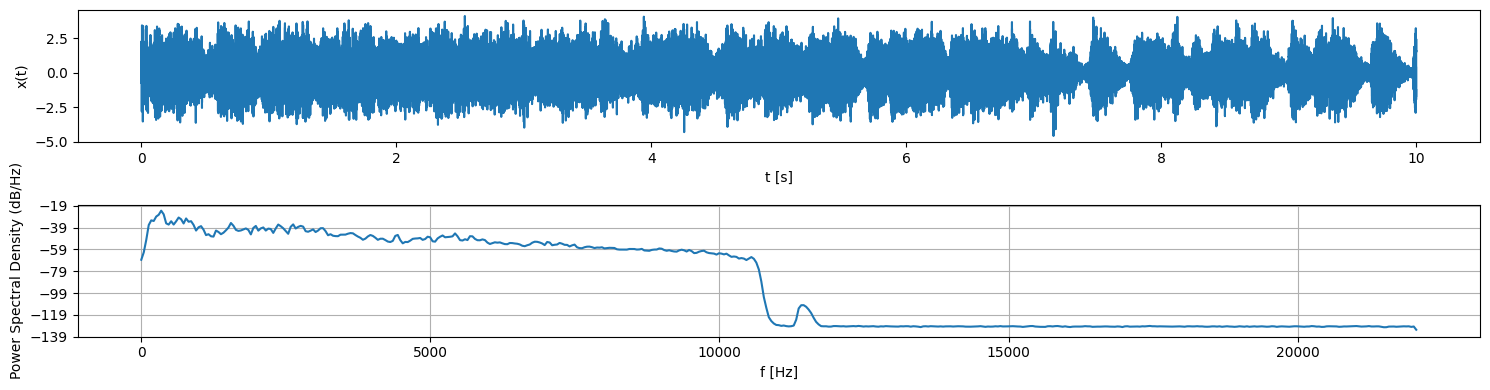

In [13]:
subject = 0
channel = 0
fs = 44100
plot_psd(audio0[0][1][None, ...], subject=subject, channel=channel, fs=fs)

### Audio (ESC-50)

In [2]:
data_path = "/home/oturgut/data/ESC-50"
df = pd.read_csv(os.path.join(data_path, 'meta/esc50.csv'))
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [8]:
categories = df["category"].values
targets = df["target"].values

In [16]:
target_dict = {targets[idx]:category for idx, category in enumerate(categories)}

In [17]:
target_dict

{0: 'dog',
 14: 'chirping_birds',
 36: 'vacuum_cleaner',
 19: 'thunderstorm',
 30: 'door_wood_knock',
 34: 'can_opening',
 9: 'crow',
 22: 'clapping',
 48: 'fireworks',
 41: 'chainsaw',
 47: 'airplane',
 31: 'mouse_click',
 17: 'pouring_water',
 45: 'train',
 8: 'sheep',
 15: 'water_drops',
 46: 'church_bells',
 37: 'clock_alarm',
 32: 'keyboard_typing',
 16: 'wind',
 25: 'footsteps',
 4: 'frog',
 3: 'cow',
 27: 'brushing_teeth',
 43: 'car_horn',
 12: 'crackling_fire',
 40: 'helicopter',
 29: 'drinking_sipping',
 10: 'rain',
 7: 'insects',
 26: 'laughing',
 6: 'hen',
 44: 'engine',
 23: 'breathing',
 20: 'crying_baby',
 49: 'hand_saw',
 24: 'coughing',
 39: 'glass_breaking',
 28: 'snoring',
 18: 'toilet_flush',
 2: 'pig',
 35: 'washing_machine',
 38: 'clock_tick',
 21: 'sneezing',
 1: 'rooster',
 11: 'sea_waves',
 42: 'siren',
 5: 'cat',
 33: 'door_wood_creaks',
 13: 'crickets'}

In [18]:
# torch.save(target_dict, "/home/oturgut/data/processed/ESC-50/labels_dict.pt")

In [94]:
files = df["filename"].values
folds = df["fold"].values
labels = df["target"].values

In [99]:
tensors = []
targets = []

for fold in np.unique(folds):
    curr_files = files[folds == fold]
    curr_labels = labels[folds == fold]

    tensors_fold = []
    labels_fold = []
    for idx, file in enumerate(curr_files):
        file_path = os.path.join(data_path, 'audio', file)
        samplerate, data = wavfile.read(file_path)

        tensor = torch.from_numpy(data)
        if tensor.dim() == 1:
            tensor = tensor[..., None]

        tensor = tensor.transpose(1, 0)

        if tensor.shape[-1] == 0:
            continue
        
        tensor = tensor.to(dtype=torch.float32)
        tensor_normalised = ( tensor - tensor.mean(dim=-1, keepdim=True) ) / ( tensor.std(dim=-1, keepdim=True) + 1e-9 )

        tensors_fold.append(tensor_normalised)
        labels_fold.append(curr_labels[idx])

    tensors.append(tensors_fold)
    targets.append(labels_fold)

In [163]:
data_fold_0 = [("audio_mono", data.unsqueeze(0)) for data in tensors[0]]
data_fold_1 = [("audio_mono", data.unsqueeze(0)) for data in tensors[1]]
data_fold_2 = [("audio_mono", data.unsqueeze(0)) for data in tensors[2]]
data_fold_3 = [("audio_mono", data.unsqueeze(0)) for data in tensors[3]]
data_fold_4 = [("audio_mono", data.unsqueeze(0)) for data in tensors[4]]

In [166]:
# torch.save(data_fold_0, "/home/oturgut/data/processed/ESC-50/data_fold0.pt")
# torch.save(data_fold_1, "/home/oturgut/data/processed/ESC-50/data_fold1.pt")
# torch.save(data_fold_2, "/home/oturgut/data/processed/ESC-50/data_fold2.pt")
# torch.save(data_fold_3, "/home/oturgut/data/processed/ESC-50/data_fold3.pt")
# torch.save(data_fold_4, "/home/oturgut/data/processed/ESC-50/data_fold4.pt")

In [164]:
labels_fold_0 = torch.nn.functional.one_hot(torch.tensor(targets[0]), num_classes=50).to(torch.int32)
labels_fold_1 = torch.nn.functional.one_hot(torch.tensor(targets[1]), num_classes=50).to(torch.int32)
labels_fold_2 = torch.nn.functional.one_hot(torch.tensor(targets[2]), num_classes=50).to(torch.int32)
labels_fold_3 = torch.nn.functional.one_hot(torch.tensor(targets[3]), num_classes=50).to(torch.int32)
labels_fold_4 = torch.nn.functional.one_hot(torch.tensor(targets[4]), num_classes=50).to(torch.int32)

In [165]:
# torch.save(labels_fold_0, "/home/oturgut/data/processed/ESC-50/labels_fold0.pt")
# torch.save(labels_fold_1, "/home/oturgut/data/processed/ESC-50/labels_fold1.pt")
# torch.save(labels_fold_2, "/home/oturgut/data/processed/ESC-50/labels_fold2.pt")
# torch.save(labels_fold_3, "/home/oturgut/data/processed/ESC-50/labels_fold3.pt")
# torch.save(labels_fold_4, "/home/oturgut/data/processed/ESC-50/labels_fold4.pt")

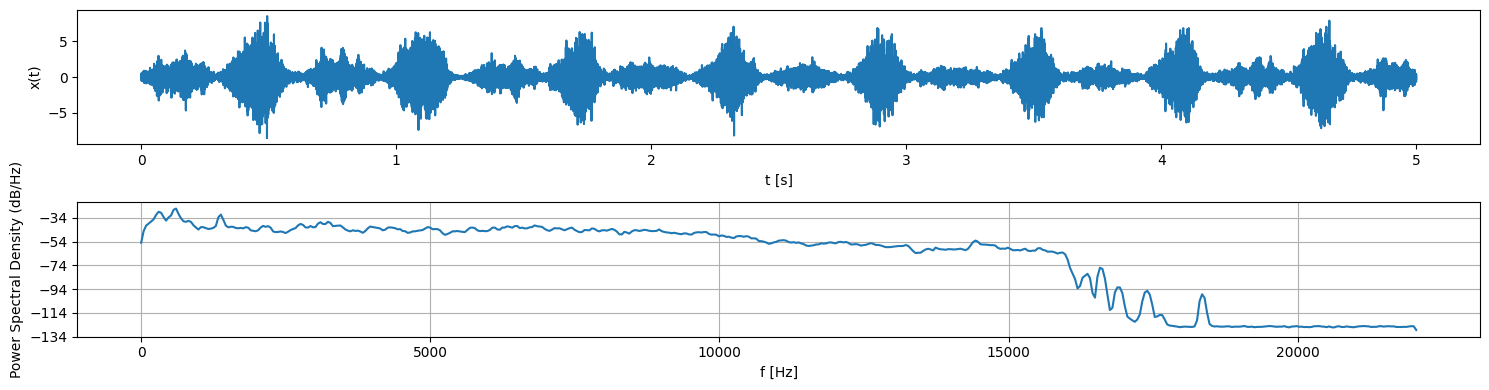

In [143]:
subject = 0
channel = 0
fs = 44100
plot_psd(data_fold_3[0][1], subject=subject, channel=channel, fs=fs)

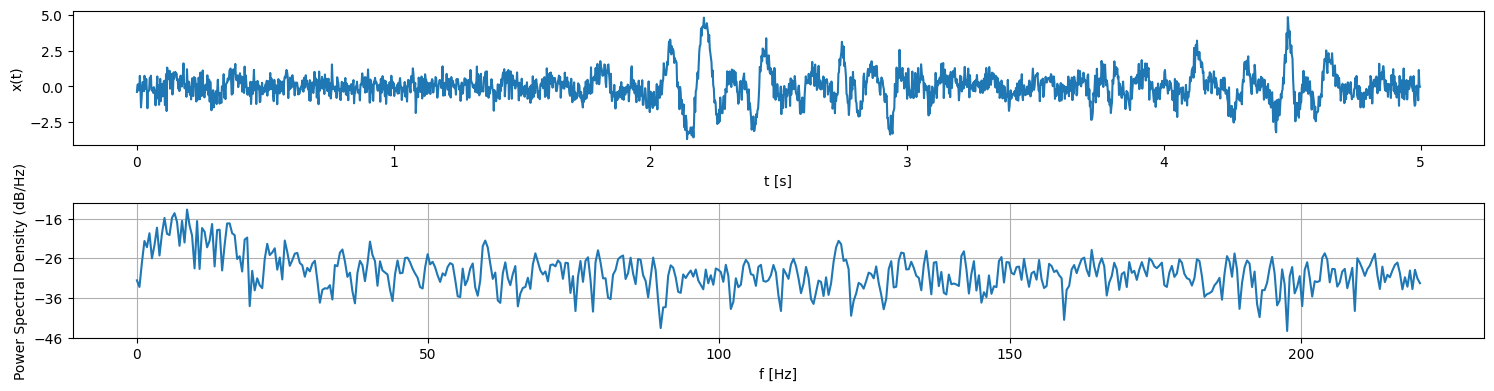

In [162]:
subject = 0
channel = 0
fs = 441
plot_psd(data_fold_3[111][1][..., ::100], subject=subject, channel=channel, fs=fs)

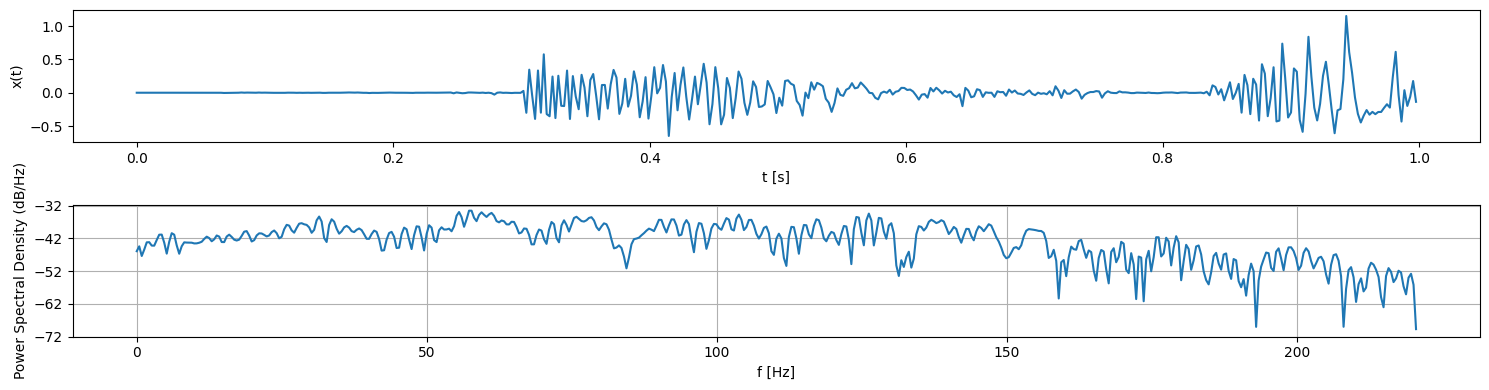

In [160]:
subject = 0
channel = 0
fs = 441
plot_psd(data_fold_3[388][1][..., :44100:100], subject=subject, channel=channel, fs=fs)

### Sleep EEG

In [302]:
dataset = "EMG"
split = "val"
sleep_eeg = torch.load(f"/home/oturgut/data/signalnet/datasets/classification/{dataset}/{split}.pt")

##### labels

In [303]:
len(sleep_eeg["labels"]), sleep_eeg["labels"].to(torch.int64).unique()

(41, tensor([0, 1, 2]))

In [304]:
labels = torch.nn.functional.one_hot(sleep_eeg["labels"].to(torch.int64)).to(torch.int32)
labels.shape, labels.dtype 

(torch.Size([41, 3]), torch.int32)

In [305]:
# torch.save(labels, f"/home/oturgut/data/processed/signalnet/classification/{dataset}/{split}_labels.pt")

In [242]:
# labels_test = torch.load("/home/oturgut/data/processed/ukbb/labelsOneHot/labels_train_CAD_all_balanced.pt")

In [191]:
# labels_test.shape, labels_test.dtype

(torch.Size([4030, 2]), torch.float32)

##### data

In [181]:
len(sleep_eeg["samples"]), sleep_eeg["samples"].shape, sleep_eeg["samples"].mean(), sleep_eeg["samples"].std(), sleep_eeg["samples"].dtype

(43673,
 torch.Size([43673, 1, 1500]),
 tensor(0.0004, dtype=torch.float64),
 tensor(0.0125, dtype=torch.float64),
 torch.float64)

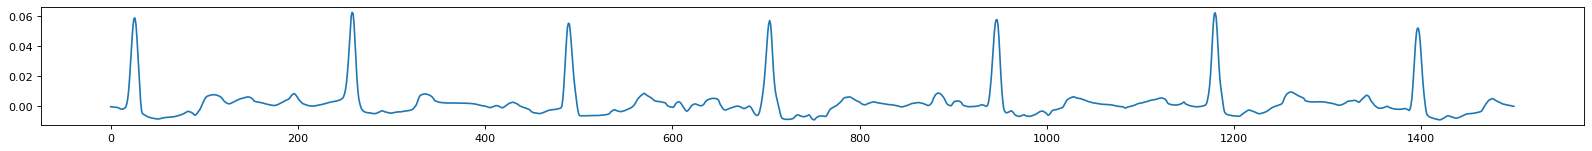

In [164]:
step = 1
plt.figure(figsize=(20, 2), dpi=80)

plt.subplot(1, 1, 1)
plt.plot(sleep_eeg["samples"][0, 0, ::step])

plt.tight_layout()
plt.show()

In [165]:
data_sleep = (sleep_eeg["samples"] - sleep_eeg["samples"].mean(dim=-1, keepdim=True)) / (sleep_eeg["samples"].std(dim=-1, keepdim=True) + 1e-9)

In [166]:
# data_sleep = (torch.tensor(sleep_eeg["samples"], dtype=torch.float32) - torch.tensor(sleep_eeg["samples"], dtype=torch.float32).mean(dim=-1, keepdim=True)) / (torch.tensor(sleep_eeg["samples"], dtype=torch.float32).std(dim=-1, keepdim=True) + 1e-9)

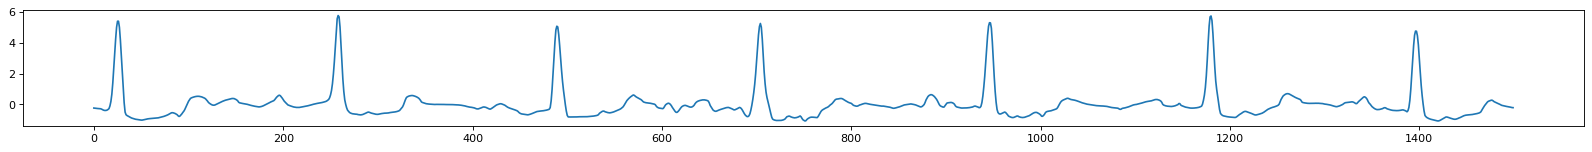

In [167]:
step = 1
plt.figure(figsize=(20, 2), dpi=80)

plt.subplot(1, 1, 1)
plt.plot(data_sleep[0, 0, ::step])

plt.tight_layout()
plt.show()

In [168]:
# sleepeeg = [("eeg_sleep", data.unsqueeze(0)) for data in data_sleep]

In [169]:
# sleepeeg = [("har", data.unsqueeze(0)) for data in data_sleep]
sleepeeg = [("ecg_singleLead", data.unsqueeze(0).to(torch.float32)) for data in data_sleep]

In [170]:
sleepeeg[0][1].shape, sleepeeg[0][1].mean(), sleepeeg[0][1].std(), sleepeeg[0][1].dtype

(torch.Size([1, 1, 1500]), tensor(3.1789e-10), tensor(1.0000), torch.float32)

In [171]:
len(sleepeeg)

43673

In [172]:
# torch.save(sleepeeg, "/home/oturgut/data/processed/signalnet/classification/ECG/train.pt")

In [68]:
data_test = torch.load("/home/oturgut/data/processed/signalnet/forecasting/data_exchange_all.pt")
data_test, data_test[0][-1].shape, data_test[0][-1].mean(), data_test[0][-1].dtype

([('exchange',
   tensor([[[ 0.0624,  0.0353,  0.0712,  ..., -0.3936, -0.4110, -0.4110]]])),
  ('exchange',
   tensor([[[-0.1430, -0.1492, -0.0297,  ..., -2.4761, -2.4773, -2.4773]]])),
  ('exchange',
   tensor([[[ 0.3406,  0.3355,  0.3349,  ..., -0.6542, -0.6632, -0.6632]]])),
  ('exchange',
   tensor([[[-1.2669, -1.2710, -1.1822,  ...,  0.8071,  0.7828,  0.7828]]])),
  ('exchange',
   tensor([[[2.8508, 2.8508, 2.8508,  ..., 0.0485, 0.0484, 0.0484]]])),
  ('exchange',
   tensor([[[-1.7182, -1.7011, -1.6242,  ..., -0.5356, -0.5404, -0.5404]]])),
  ('exchange',
   tensor([[[-0.5327, -0.5240, -0.4954,  ...,  0.3602,  0.3320,  0.3320]]])),
  ('exchange',
   tensor([[[-1.7406, -1.7589, -1.7306,  ...,  0.2625,  0.2568,  0.2568]]]))],
 torch.Size([1, 1, 7588]),
 tensor(-1.8601e-07),
 torch.float32)

In [70]:
ecg0 = torch.load("/home/oturgut/data/processed/mimic-ecg-text/ecgs_val_10k_clean.pt")
ecg0.shape

torch.Size([9661, 12, 5000])

In [179]:
len(data_test)

321

In [304]:
data_new = [(data[0], data[-1].to(torch.float32)) for data in data_test]
data_new[0][-1].shape, data_new[0][-1].dtype

(torch.Size([1, 1, 5120]), torch.float32)

In [305]:
len(data_new)

21

In [306]:
# torch.save(data_new, "/home/oturgut/data/processed/signalnet/classification/FD-B/val.pt")

In [251]:
# sleep0 = torch.load("/home/oturgut/data/processed/SleepEEG/sleepeeg_train.pt")

In [17]:
len(sleep0)

371055

In [22]:
sleep0[0][-1].shape, sleep0[0][-1].mean(), sleep0[0][-1].std()

(torch.Size([1, 178]), tensor(-2.6789e-09), tensor(1.0000))

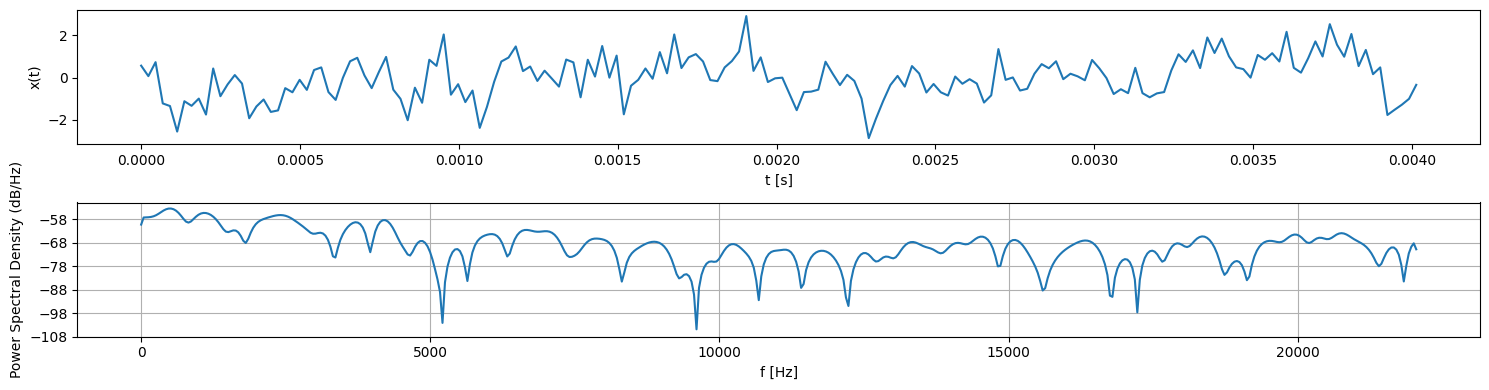

In [21]:
subject = 0
channel = 0
fs = 44100
plot_psd(sleep0[0][1][None, ...], subject=subject, channel=channel, fs=fs)

### ETT

In [89]:
etth = torch.load("/home/oturgut/data/processed/signalnet/classification/EMG/train.pt")
etth = torch.load("/home/oturgut/data/processed/signalnet/forecasting/data_etth_all.pt")

In [ ]:
etth["samples"].shape

In [91]:
len(etth)

2

In [92]:
etth[0][1].shape, etth[0][1].mean(), etth[0][1].std()

(torch.Size([1, 7, 17420]), tensor(2.3275e-08), tensor(1.0000))

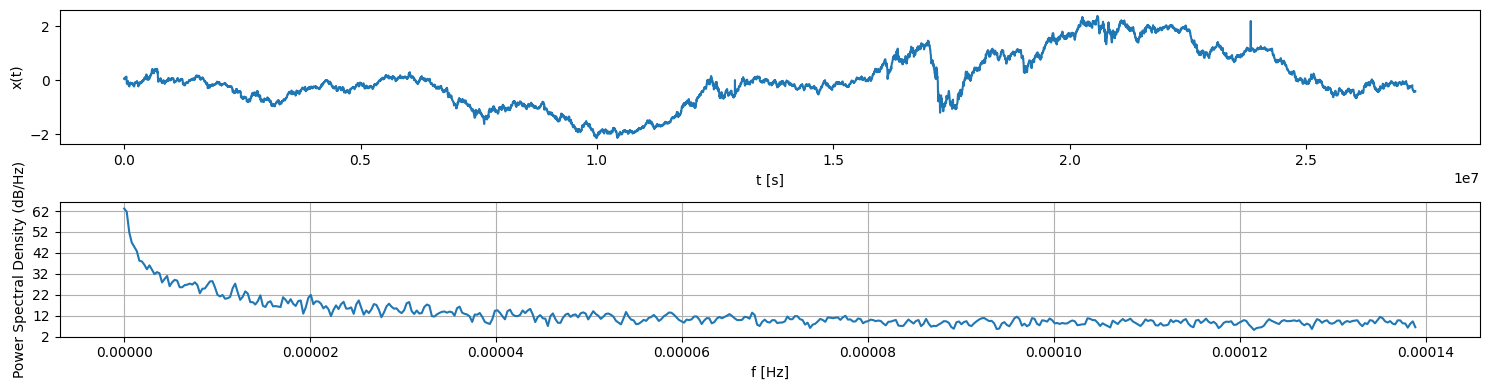

In [88]:
subject = 0
channel = 0
fs = 0.000277778
plot_psd(etth[0][1][...], subject=subject, channel=channel, fs=fs)

### TDBrain

In [3]:
def list_files(rootdir):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)
        if os.path.isdir(curr_object): 
            files += list_files(curr_object)
        elif ".vhdr" in curr_object:
            files.append(curr_object)

    return files

# Replace 'directory_path' with the path of the directory you want to search
directory_path = '/home/oturgut/data/TDBrain/'
files = list_files(directory_path)

In [4]:
len(files)

2692

In [5]:
chOrder_standard_tuev = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', \
                         'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF']

In [6]:
chOrder_standard = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

In [7]:
data_raw = mne.io.read_raw_brainvision(files[0], verbose=False)
print(data_raw.ch_names)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', 'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', 'OrbOcc', 'Mass']


In [8]:
drop_channels = [ch for ch in data_raw.ch_names if ch not in chOrder_standard]
print(drop_channels)

['FC3', 'FCz', 'FC4', 'CP3', 'CPz', 'CP4', 'Oz', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', 'OrbOcc', 'Mass']


In [9]:
def load_data(file, normalise=True):
    data_raw = mne.io.read_raw_brainvision(file, verbose=False)

    if drop_channels is not None:
        useless_chs = []
        for ch in drop_channels:
            if ch in data_raw.ch_names:
                useless_chs.append(ch)
        data_raw.drop_channels(useless_chs)

    if chOrder_standard is not None and len(chOrder_standard) == len(data_raw.ch_names):
        data_raw.reorder_channels(chOrder_standard)

    if data_raw.ch_names != chOrder_standard:
        raise Exception("channel order is wrong!")

    data = data_raw.load_data(verbose=False)._data

    if normalise:
        data = ( data - data.mean(axis=-1, keepdims=True) ) / ( data.std(axis=-1, keepdims=True) + 1e-9 )

    return data


if __name__ == "__main__":
    num_workers = 24
    with Pool(processes=num_workers) as pool:
        # Use the pool.map function to apply the square function to each element in the numbers list
        data_tdb = pool.map(load_data, files)

In [10]:
len(data_tdb), data_tdb[1000].shape, data_tdb[1000].dtype

(2692, (19, 60015), dtype('float64'))

In [13]:
data_tdb[100].min(), data_tdb[100].max(), data_tdb[100].mean(), data_tdb[100].std()

(-3.598114747348022,
 11.516004063002264,
 6.688131643882883e-15,
 0.9999785230383272)

In [14]:
tdbrain = [("eeg_10-20", torch.tensor(data, dtype=torch.float32)) for data in data_tdb]

In [15]:
len(tdbrain)

2692

In [18]:
tdbrain

[('eeg_10-20',
  tensor([[-2.0500, -2.1159, -2.2176,  ..., -0.3777, -0.2968, -0.4531],
          [-1.8210, -1.8786, -1.9954,  ..., -0.6954, -0.5279, -0.5973],
          [-2.1803, -2.2538, -2.3763,  ..., -1.4595, -1.3056, -1.5225],
          ...,
          [-2.8479, -2.8887, -2.9231,  ..., -0.1633, -0.0044, -0.1354],
          [-2.5242, -2.4914, -2.4662,  ...,  0.8592,  0.8789,  0.7945],
          [-3.0386, -2.9563, -2.8793,  ...,  0.3093,  0.2950,  0.1070]])),
 ('eeg_10-20',
  tensor([[-0.7696, -0.7386, -0.7320,  ...,  1.1946,  1.2033,  1.2144],
          [-0.9255, -0.8815, -0.8458,  ...,  1.4560,  1.4335,  1.4313],
          [-0.9194, -0.8342, -0.7697,  ...,  1.2985,  1.3288,  1.3670],
          ...,
          [-1.2812, -1.1872, -1.1184,  ...,  1.5979,  1.6088,  1.6225],
          [-1.1347, -1.0382, -0.9334,  ...,  2.1255,  2.1034,  2.1301],
          [-0.6529, -0.4910, -0.3421,  ...,  2.6657,  2.6036,  2.6036]])),
 ('eeg_10-20',
  tensor([[-1.7607, -1.7697, -1.8560,  ...,  0.9816,  0

In [16]:
tdbrain[0][1].shape

torch.Size([19, 60008])

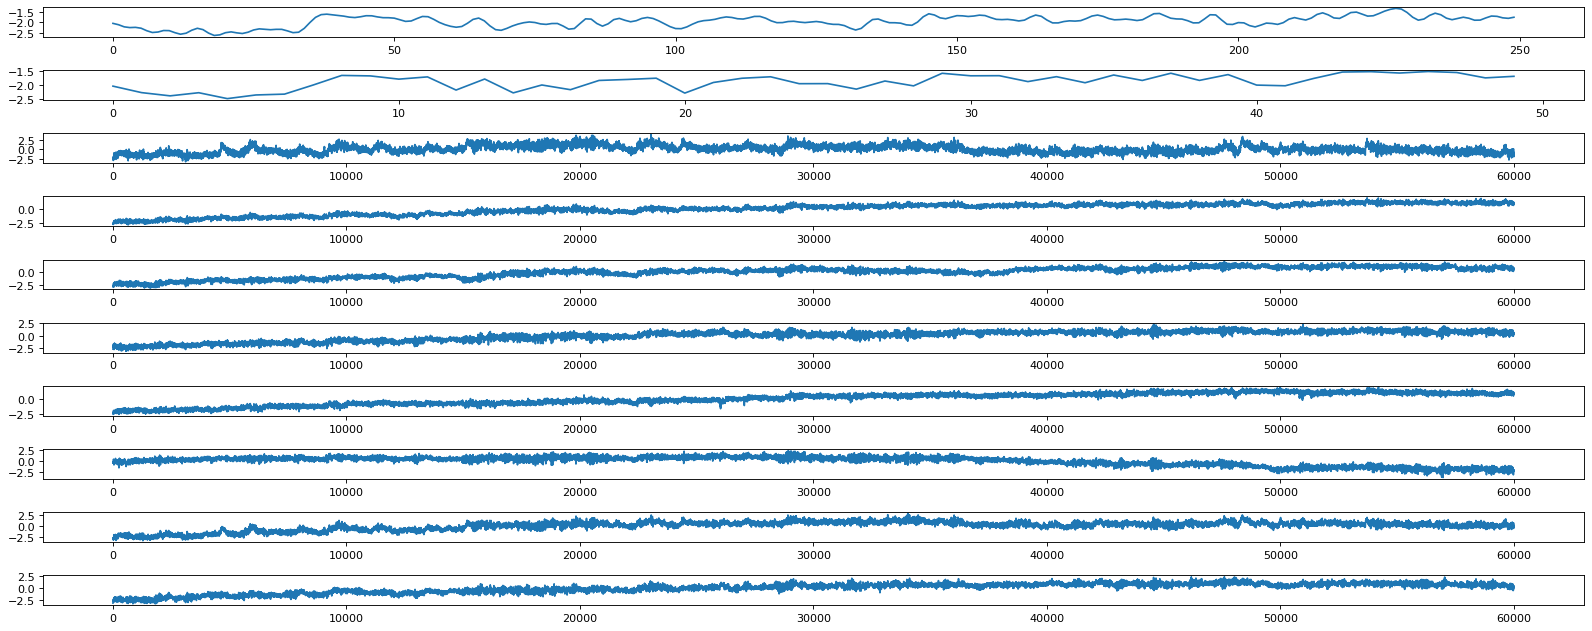

In [22]:
subject = 0
data = tdbrain[subject][1]

step = 1
plt.figure(figsize=(20, 8), dpi=80)

plt.subplot(10,1,1)
plt.plot(data[0, :250:step])

plt.subplot(10,1,2)
plt.plot(data[0, :250:step*5])

plt.subplot(10,1,3)
plt.plot(data[2, ::step])

plt.subplot(10,1,4)
plt.plot(data[4, ::step])

plt.subplot(10,1,5)
plt.plot(data[6, ::step])

plt.subplot(10,1,6)
plt.plot(data[8, ::step])

plt.subplot(10,1,7)
plt.plot(data[12, ::step])

plt.subplot(10,1,8)
plt.plot(data[14, ::step])

plt.subplot(10,1,9)
plt.plot(data[16, ::step])

plt.subplot(10,1,10)
plt.plot(data[18, ::step])

plt.tight_layout()
plt.show()

In [23]:
# torch.save(tdbrain, "/home/oturgut/data/processed/TDBrain/data.pt")

In [23]:
data_tdb = torch.load("/home/oturgut/data/processed/TDBrain/tdbrain.pt")

In [25]:
data_tdb[0]

('eeg_rest',
 tensor([[ 1.1701,  1.1375,  1.1576,  ..., -1.7801, -1.7819, -1.7904],
         [-1.9653, -2.0092, -1.9878,  ...,  1.3323,  1.3235,  1.3177],
         [ 1.5427,  1.5113,  1.5244,  ..., -1.4952, -1.4879, -1.4801],
         ...,
         [-0.1110, -0.1656, -0.2020,  ..., -0.0180,  0.1317,  0.1964],
         [-0.0999, -0.1636, -0.0439,  ...,  0.5723,  0.5704,  0.5183],
         [-0.3033, -0.4112, -0.4053,  ...,  1.2283,  1.2271,  1.2153]]))

In [33]:
data_tdb[0][1].shape, data_tdb[0][1], data_tdb[0][1].std()

(torch.Size([33, 60003]),
 tensor([[ 1.1701,  1.1375,  1.1576,  ..., -1.7801, -1.7819, -1.7904],
         [-1.9653, -2.0092, -1.9878,  ...,  1.3323,  1.3235,  1.3177],
         [ 1.5427,  1.5113,  1.5244,  ..., -1.4952, -1.4879, -1.4801],
         ...,
         [-0.1110, -0.1656, -0.2020,  ..., -0.0180,  0.1317,  0.1964],
         [-0.0999, -0.1636, -0.0439,  ...,  0.5723,  0.5704,  0.5183],
         [-0.3033, -0.4112, -0.4053,  ...,  1.2283,  1.2271,  1.2153]]),
 tensor(1.0000))

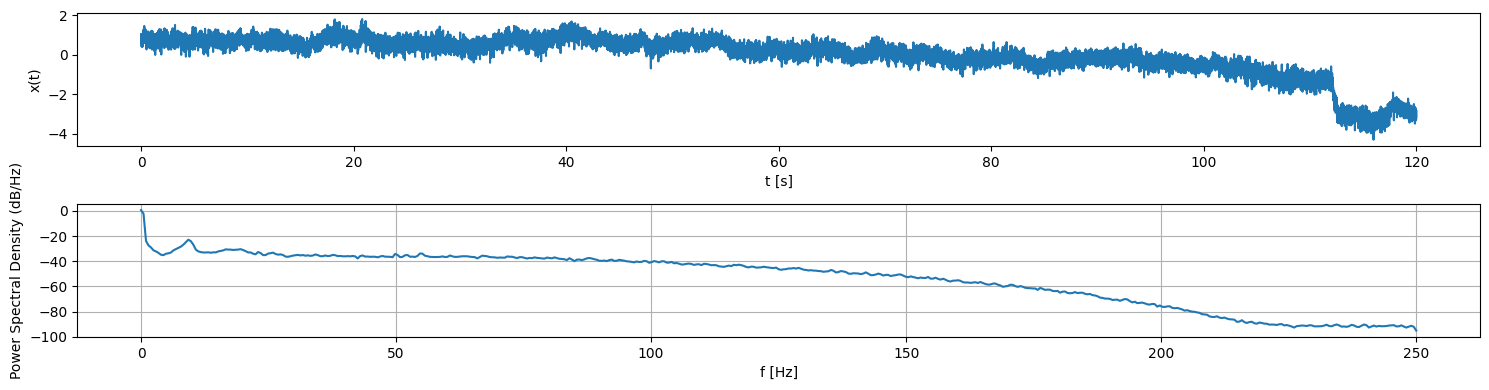

In [29]:
subject = 0
channel = 5
fs = 500
plot_psd(data_tdb[0][1][None, ...], subject=subject, channel=channel, fs=fs)

### Visualisation

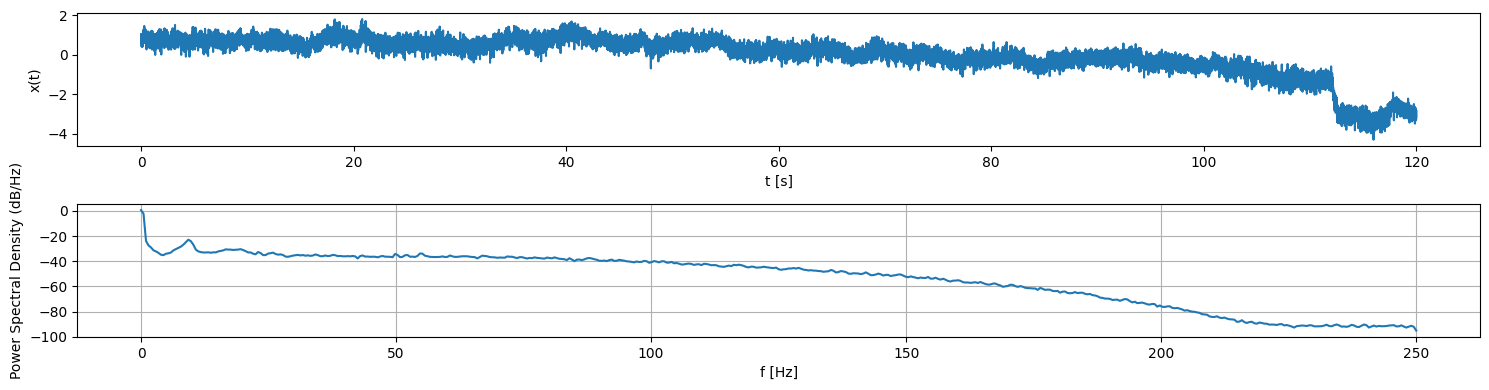

In [26]:
subject = 0
channel = 5
fs = 500
plot_psd(data_tdb[0][1][None, ...], subject=subject, channel=channel, fs=fs)

In [7]:
sleepeeg = torch.load("/home/oturgut/data/processed/signalnet/sleepeeg_train.pt")

In [8]:
sleepeeg[0][1].shape

torch.Size([1, 178])

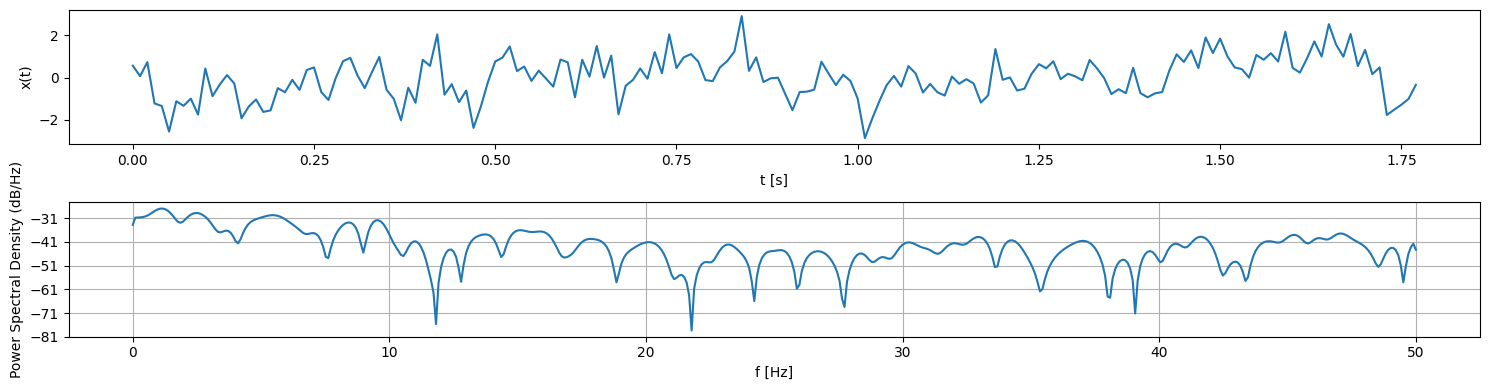

In [9]:
subject = 0
channel = 0
fs = 100
plot_psd(sleepeeg[0][1][None, ...], subject=subject, channel=channel, fs=fs)

In [10]:
audio = torch.load("/home/oturgut/data/processed/signalnet/audioset_20k.pt")

In [11]:
audio[0][1].shape

torch.Size([1, 441000])

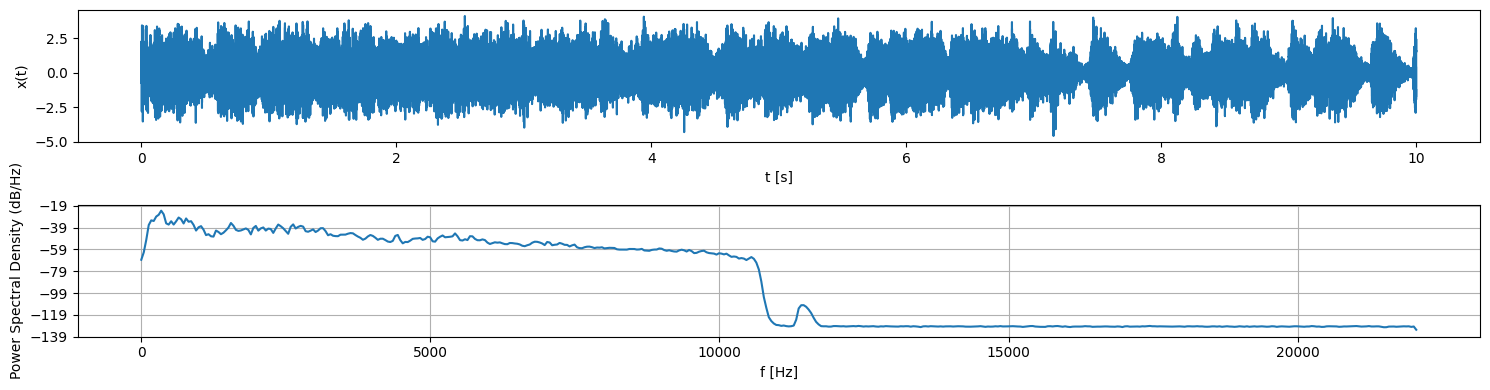

In [12]:
subject = 0
channel = 0
fs = 44100
plot_psd(audio[0][1][None, ...], subject=subject, channel=channel, fs=fs)

In [13]:
ecg = torch.load("/home/oturgut/data/processed/mimic-ecg-text/ecgs_val_10k_clean.pt")

In [14]:
ecg.shape

torch.Size([9661, 12, 5000])

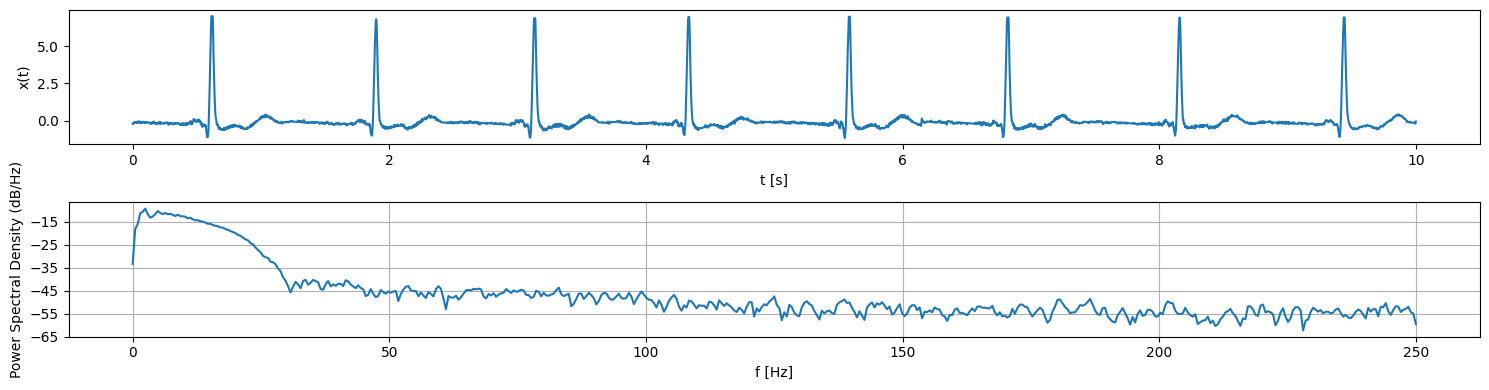

In [15]:
subject = 0
channel = 0
fs = 500
plot_psd(ecg[...], subject=subject, channel=channel, fs=fs)

In [ ]:
# torch.save(tdbrain, "/home/oturgut/data/processed/signalnet/tdbrain.pt")

### Visualisation

In [4]:
ecg = torch.load("/home/oturgut/data/processed/mimic-ecg-text/ecgs_val_10k_clean.pt")

In [5]:
audio = torch.load("/home/oturgut/data/processed/AudioSet/audioset_20k.pt")

In [6]:
tdb = torch.load("/home/oturgut/data/processed/TDBrain/tdbrain.pt")

In [7]:
sleep = torch.load("/home/oturgut/data/processed/signalnet/classification/SleepEEG/test.pt")

In [8]:
tuev = torch.load("/home/oturgut/data/processed/TUAB/test/data.pt")
tuab = torch.load("/home/oturgut/data/processed/TUEV/test/data.pt")

In [26]:
seed = torch.load("/home/oturgut/data/processed/SEED/data_seed_all.pt")

In [27]:
print(ecg.shape)
print(audio[0][1].shape)
print(tdb[0][1].shape)
print(sleep[0][1].shape)
print(tuab[0][1].shape)
print(tuev[0][1].shape)
print(seed[0][1].shape)

torch.Size([9661, 12, 5000])
torch.Size([1, 441000])
torch.Size([33, 60003])
torch.Size([1, 1, 178])
torch.Size([19, 1000])
torch.Size([19, 2000])
torch.Size([19, 37001])


In [20]:
plt.rcParams.update({'font.size': 13})

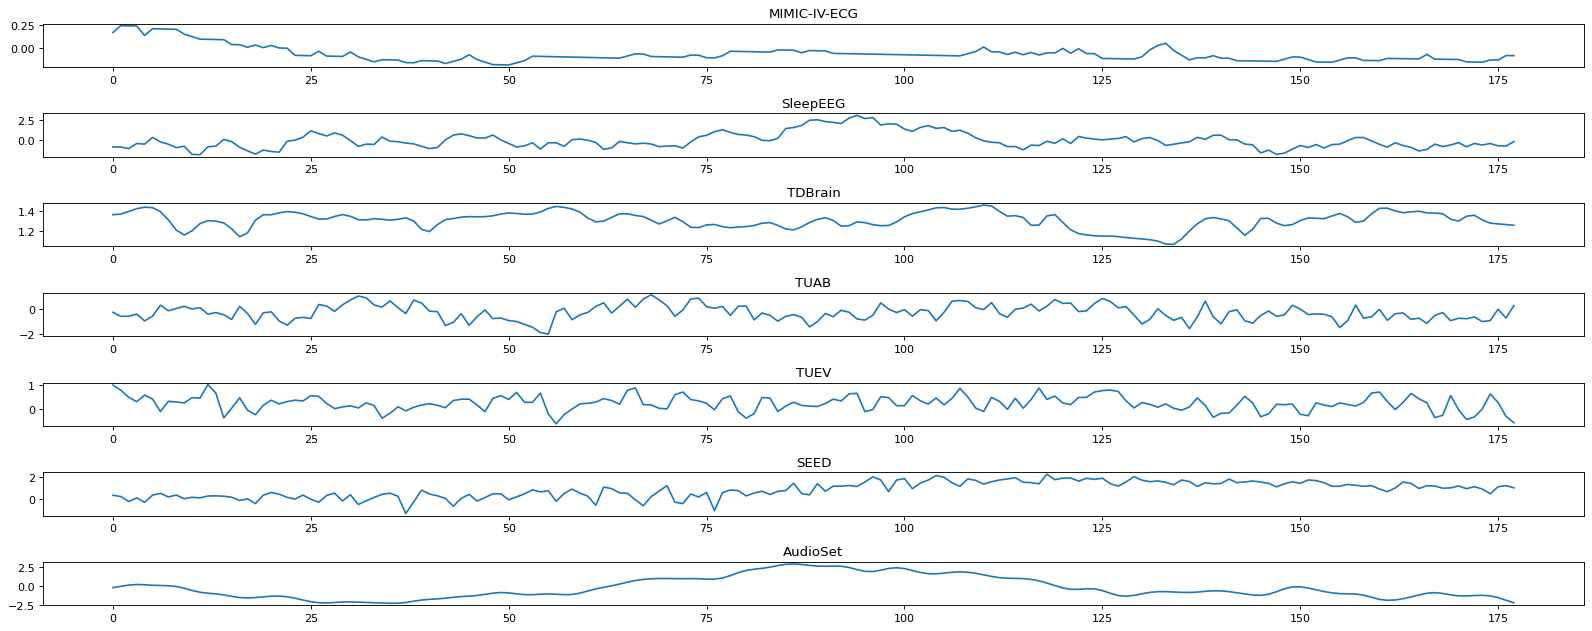

In [28]:
step = 1
plt.figure(figsize=(20, 8), dpi=80)

plt.subplot(7, 1, 1)
plt.plot(ecg[0, 0, 178*3:178*4:step])
plt.title("MIMIC-IV-ECG")

plt.subplot(7, 1, 2)
plt.plot(sleep[0][1][0, 0, ::step])
plt.title("SleepEEG")

plt.subplot(7, 1, 3)
plt.plot(tdb[0][1][0, 178*30:178*31:step])
plt.title("TDBrain")

plt.subplot(7, 1, 4)
plt.plot(tuab[100][1][0, 178*4:178*5:step])
plt.title("TUAB")

plt.subplot(7, 1, 5)
plt.plot(tuev[100][1][0, 178*4:178*5:step])
plt.title("TUEV")

plt.subplot(7, 1, 6)
plt.plot(seed[100][1][0, 178*55:178*56:step])
plt.title("SEED")

plt.subplot(7, 1, 7)
plt.plot(audio[0][1][0, 10000:10178:step])
plt.title("AudioSet")

plt.tight_layout()
plt.show()

In [ ]:
tst_data = torch.load("/home/oturgut/data/processed/signalnet/data_val_new.pt")

In [ ]:
tst_data[0][1].shape